# Predict residence time based on scavenging fields

$$ \frac{\partial [dPb]}{\partial t} = - (\beta \cdot P_{litho,authigenic} + (1-\beta) \cdot P_{biogenic} ) \cdot k_{p} \cdot [dPb] $$

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
import cmocean
import pickle
from matplotlib.colors import ListedColormap
import matplotlib.backends.backend_pdf

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Colors:
land_color  = '#a9a7a2'
g           = '#c1c1c1'
colors      = ['#b3cde0','#005b96','#b5754c','#dbd3ce','#c36f79','#a2444f']

#### Load files:

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = mfile['nav_lon'].values
mesh_lat = mfile['nav_lat'].values
mask     = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values
mesh_dz      = np.diff(mesh_depth, prepend=0)

# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

Load particle fields

In [4]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
dset          = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/BLING-EPM101/ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons    = dset['nav_lon'].values
ANHA4_lats    = dset['nav_lat'].values
ANHA4_depths  = dset['deptht'].values

# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
ANHA12_lons = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats = mesh_lat[imin:imax,jmin:jmax]

# Forcing fields:
year  = 2002
oMn   = np.zeros((12,len(mesh_depth),isize,jsize)); fpop  = np.zeros((12,len(mesh_depth),isize,jsize));
fpops = np.zeros((12,len(mesh_depth),isize,jsize)); biom  = np.zeros((12,len(mesh_depth),isize,jsize));
for month in range(1,13):
    df = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-tuning-202302/base/Pb_scavenging_y{year}m{month:02}.nc')
    oMn[month-1,:,:,:]   = df['oxidisMn'].values[:,imin:imax,jmin:jmax]
    fpop[month-1,:,:,:]  = df['fpop'].values[:,imin:imax,jmin:jmax]
    fpops[month-1,:,:,:] = df['fpop-sink'].values[:,imin:imax,jmin:jmax]
    biom[month-1,:,:,:]  = df['biomass'].values[:,imin:imax,jmin:jmax]

Create mask for different regions to create average profiles over:

In [5]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

#### Functions

In [6]:
def calc_regional_profile(variable):
    # Function to calculate mean profiles of residence time for each of the 4 regions
    
    # Separate based on region:
    CB_variable  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    CAA_variable = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, variable)
    BB_variable  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    LS_variable  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    
    # and mask land:
    CB_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CB_variable)
    CAA_variable = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CAA_variable)
    BB_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), BB_variable)
    LS_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), LS_variable)

    # Calculate mean over each of the regions:
    CB_mean_var    = np.ma.mean(CB_variable , axis=(1,2))
    CAA_mean_var   = np.ma.mean(CAA_variable, axis=(1,2))
    BB_mean_var    = np.ma.mean(BB_variable , axis=(1,2))
    LS_mean_var    = np.ma.mean(LS_variable , axis=(1,2))

    return CB_mean_var.filled(fill_value=np.nan), CAA_mean_var.filled(fill_value=np.nan), \
                BB_mean_var.filled(fill_value=np.nan), LS_mean_var.filled(fill_value=np.nan)

In [7]:
def particle_figure(particle_fields):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.tick_params(labelsize=12, pad=0)
        axis.xaxis.tick_top()    
        axis.xaxis.set_label_position('top') 
        
    ax[0].set_ylabel('Depth [m]', fontsize=12)
    ax[0].set_title('Full depth', fontsize=14)
    ax[1].set_title('Surface', fontsize=14)

    ax[0].set_ylim(2500,0); #ax[0].set_xlim(-0.01,2);
    ax[1].set_ylim(80,0);   #ax[1].set_xlim(-0.01,2);
    
    CB_mean_var, CAA_mean_var, BB_mean_var, LS_mean_var = calc_regional_profile(particle_fields)
    var_list = [CB_mean_var, CAA_mean_var, BB_mean_var, LS_mean_var]        
    names    = ['Canada Basin','CAA','Baffin Bay','Labrador Sea']    
    
    for axis in ax.ravel():
        for n in range(0,len(var_list)):
            # Model: ---------------------------------------------------------------------------------
            axis.plot(var_list[n],  mesh_depth, '-', c=colors[n], label=f'{names[n]}', linewidth=3) # CB
        
    ax[1].legend(fontsize=12, loc=4, frameon=False)
    
    return

In [115]:
def plot_regional(ax, tau, title, legend=False):
    
    ax.plot(tau[0][0], mesh_depth, label='CB', linewidth=0.8)
    ax.plot(tau[0][1], mesh_depth, label='CAA', linewidth=0.8)
    ax.plot(tau[0][2], mesh_depth, label='BB', linewidth=0.8)
    ax.plot(tau[0][3], mesh_depth, label='LS', linewidth=0.8)
    
    # Manually set the position and relative size of the inset axes within ax1    
    ax.tick_params(labelsize=6, pad=0)
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    
    if legend:
        ax.legend(loc=(-0.35, 0.98), fontsize=6, frameon=False)
        
    ax.set_title(title, fontsize=7)
    return

In [10]:
def calc_residence_time_kscav(part_scav, k=1, regional=False):
    
    scav_total = np.nansum(k*part_scav, axis=0)   
    
    # mask zero values:
    scav_totalm = np.ma.masked_where(scav_total <= 0, scav_total/12)
    
    # Convert residence time from seconds to years:
    residence_time = 1 / (scav_totalm*3600*24*365)
    
    if regional:
        return [calc_regional_profile(residence_time)]
    else:
        return residence_time

In [118]:
def plot_regional_tau(tau, keys=['','','','']):
    
    fig, ax = plt.subplots(1, 4, figsize=(8,3), dpi=300)

    fig.suptitle(f'p = {keys[0].split("-b")[0][1:]}', fontsize=7, fontweight='bold')

    for i, axis in enumerate(ax.ravel()):
        axis.set_ylim(2500,0);
        axis.set_xlim(0,np.nanmax(tau[f'{keys[i]}'][0][0]));
        axis.set_xlabel('Residence time (years)', fontsize=6)

    ax[0].set_ylabel('Depth [m]', fontsize=6)
    plot_regional(ax[0], tau[f'{keys[0]}'], f'beta={keys[0].split("-b")[1]}', legend=True)
    plot_regional(ax[1], tau[f'{keys[1]}'], f'beta={keys[1].split("-b")[1]}')
    plot_regional(ax[2], tau[f'{keys[2]}'], f'beta={keys[2].split("-b")[1]}')
    plot_regional(ax[3], tau[f'{keys[3]}'], f'beta={keys[3].split("-b")[1]}')

    left, bottom, width, height = [0.11, 0.1, 0.06, 0.23]
    ax1 = fig.add_axes([left, bottom, width, height]);
    ax2 = fig.add_axes([left*3.2, bottom, width, height]);
    ax3 = fig.add_axes([left*5.4, bottom, width, height]);
    ax4 = fig.add_axes([left*7.5, bottom, width, height]); 
    plot_regional(ax1, tau[f'{keys[0]}'], '')
    plot_regional(ax2, tau[f'{keys[1]}'], '')
    plot_regional(ax3, tau[f'{keys[2]}'], '')
    plot_regional(ax4, tau[f'{keys[3]}'], '')

    for i,axis in enumerate([ax1,ax2,ax3,ax4]):
        axis.set_ylim(60,0);     
#         axis.set_xlim(0, np.nanmax(tau[f'{keys[i]}'][0][0][0:10]))
        axis.set_xlim(0,2e-2)
        axis.locator_params(axis='x', nbins=5)
        axis.tick_params(labelsize=5, pad=0)
        for label in axis.get_xticklabels()[::2]:
            label.set_visible(False)
    
    plt.tight_layout()
    return fig

In [98]:
def calc_kscav(ln_fpop=False, ln_fpop_sink=True, ln_biomass=True, beta=0.005, power=1):
    # beta --- fraction lithogenic
    
    litho_particles_norm = (oMn[:,:,:,:]/np.nanmax(oMn[:,:,:,:]))
    bio_particles        = ln_fpop*fpop[:,:,:,:] + ln_fpop_sink*fpops[:,:,:,:] + ln_biomass*biom[:,:,:,:]
    bio_particles_norm   = bio_particles/np.nanmax(bio_particles)
    bio_particles_norm[bio_particles_norm < 0] = 0
    
#     particles            = litho_particles_norm*beta + (1-beta)*(bio_particles_norm)/(np.amax(bio_particles_norm)**(1-power))
    particles            = litho_particles_norm*beta + (1-beta)*(bio_particles_norm)
    part_scav            = particles**power
    return part_scav

#### Estimations

In [ ]:
# use method 1 with k = 4e-5, beta = 0.005, 0.01, 0.05, 0.10, power=0.15, 0.50 to check residence time profiles

In [99]:
power_exps = [0.15, 0.5] #[0.15, 0.25, 0.5, 1.0]
betas      = [0.005, 0.01, 0.05, 0.10]

kscav     = {}
tau       = {}
for p in power_exps:    
    for b in betas:
        kscav[f'p{p}-b{b}'] = calc_kscav(beta=b, power=p)
        tau[f'p{p}-b{b}']   = calc_residence_time_kscav(kscav[f'p{p}-b{b}'], k=4e-5, regional=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


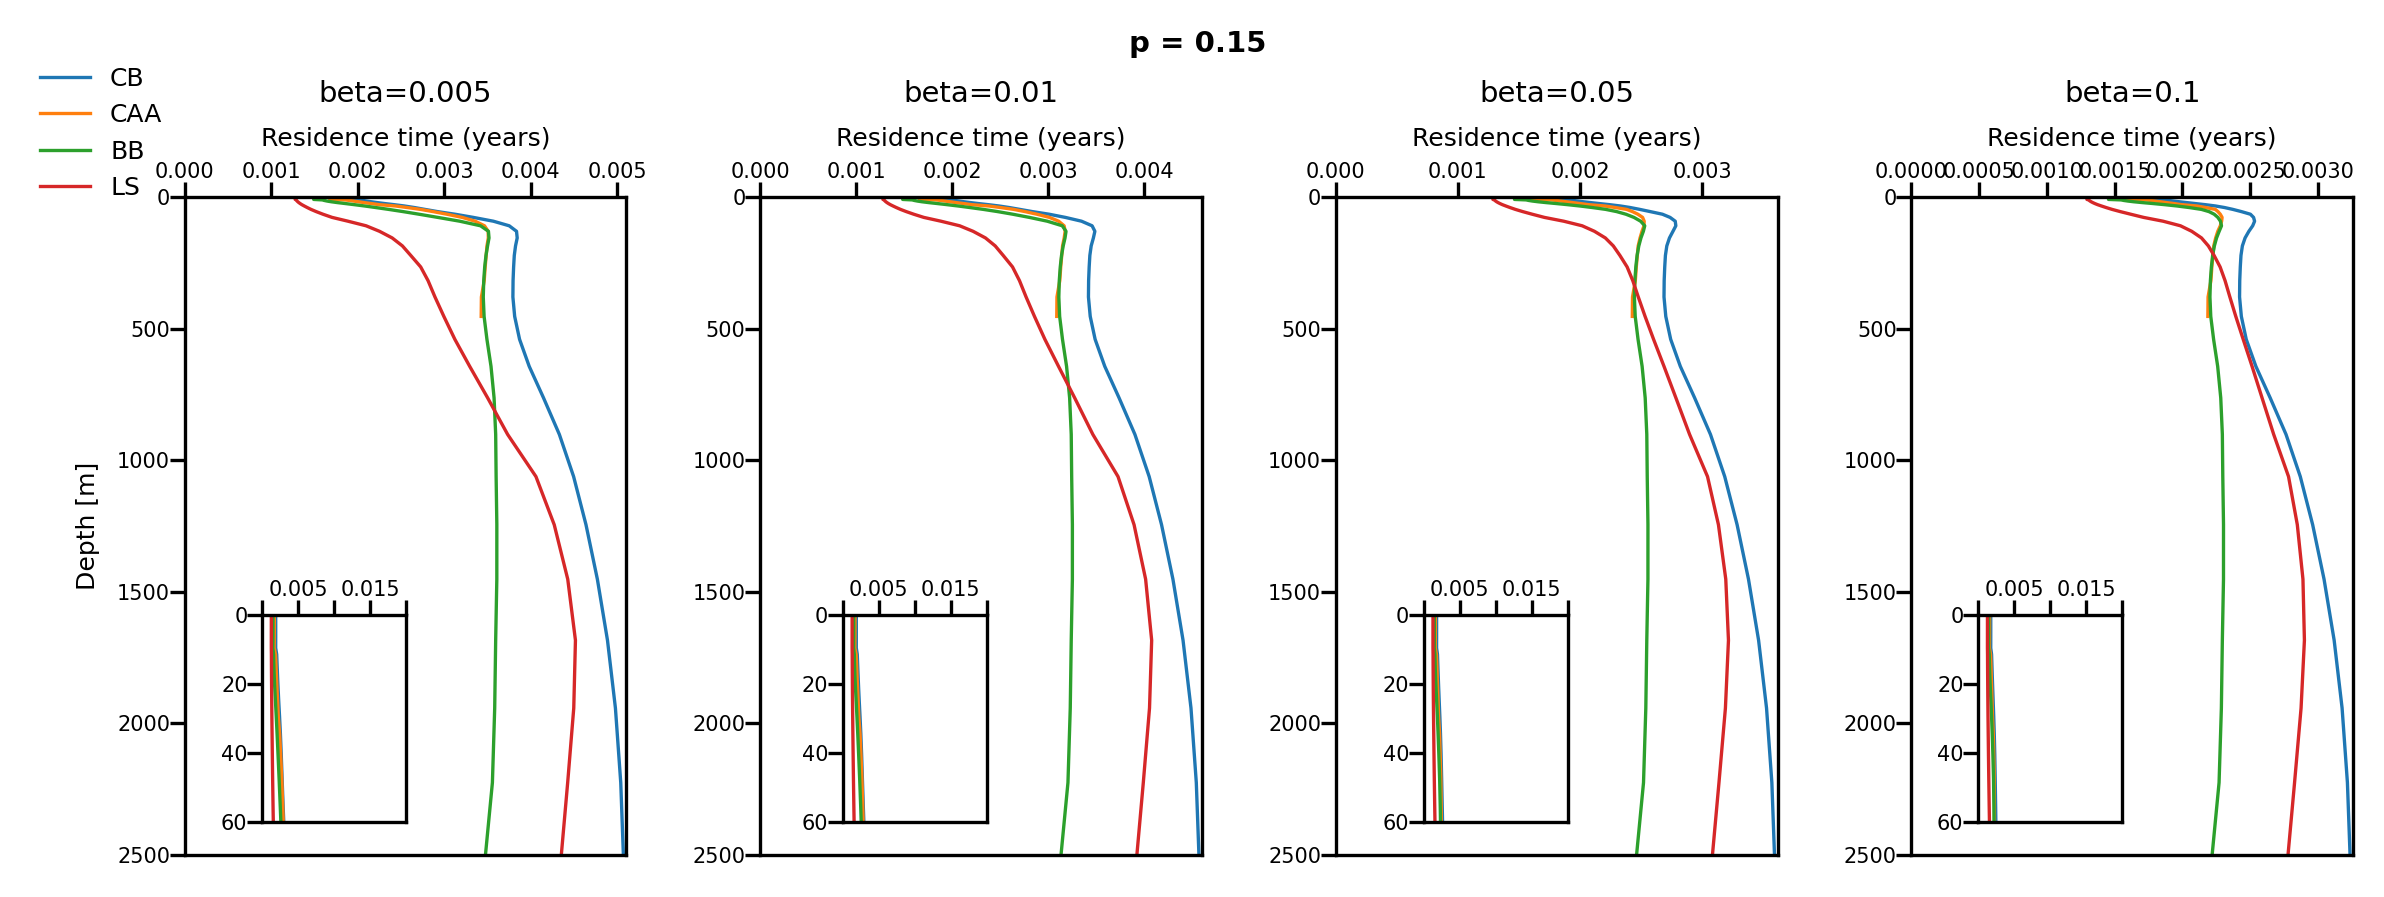

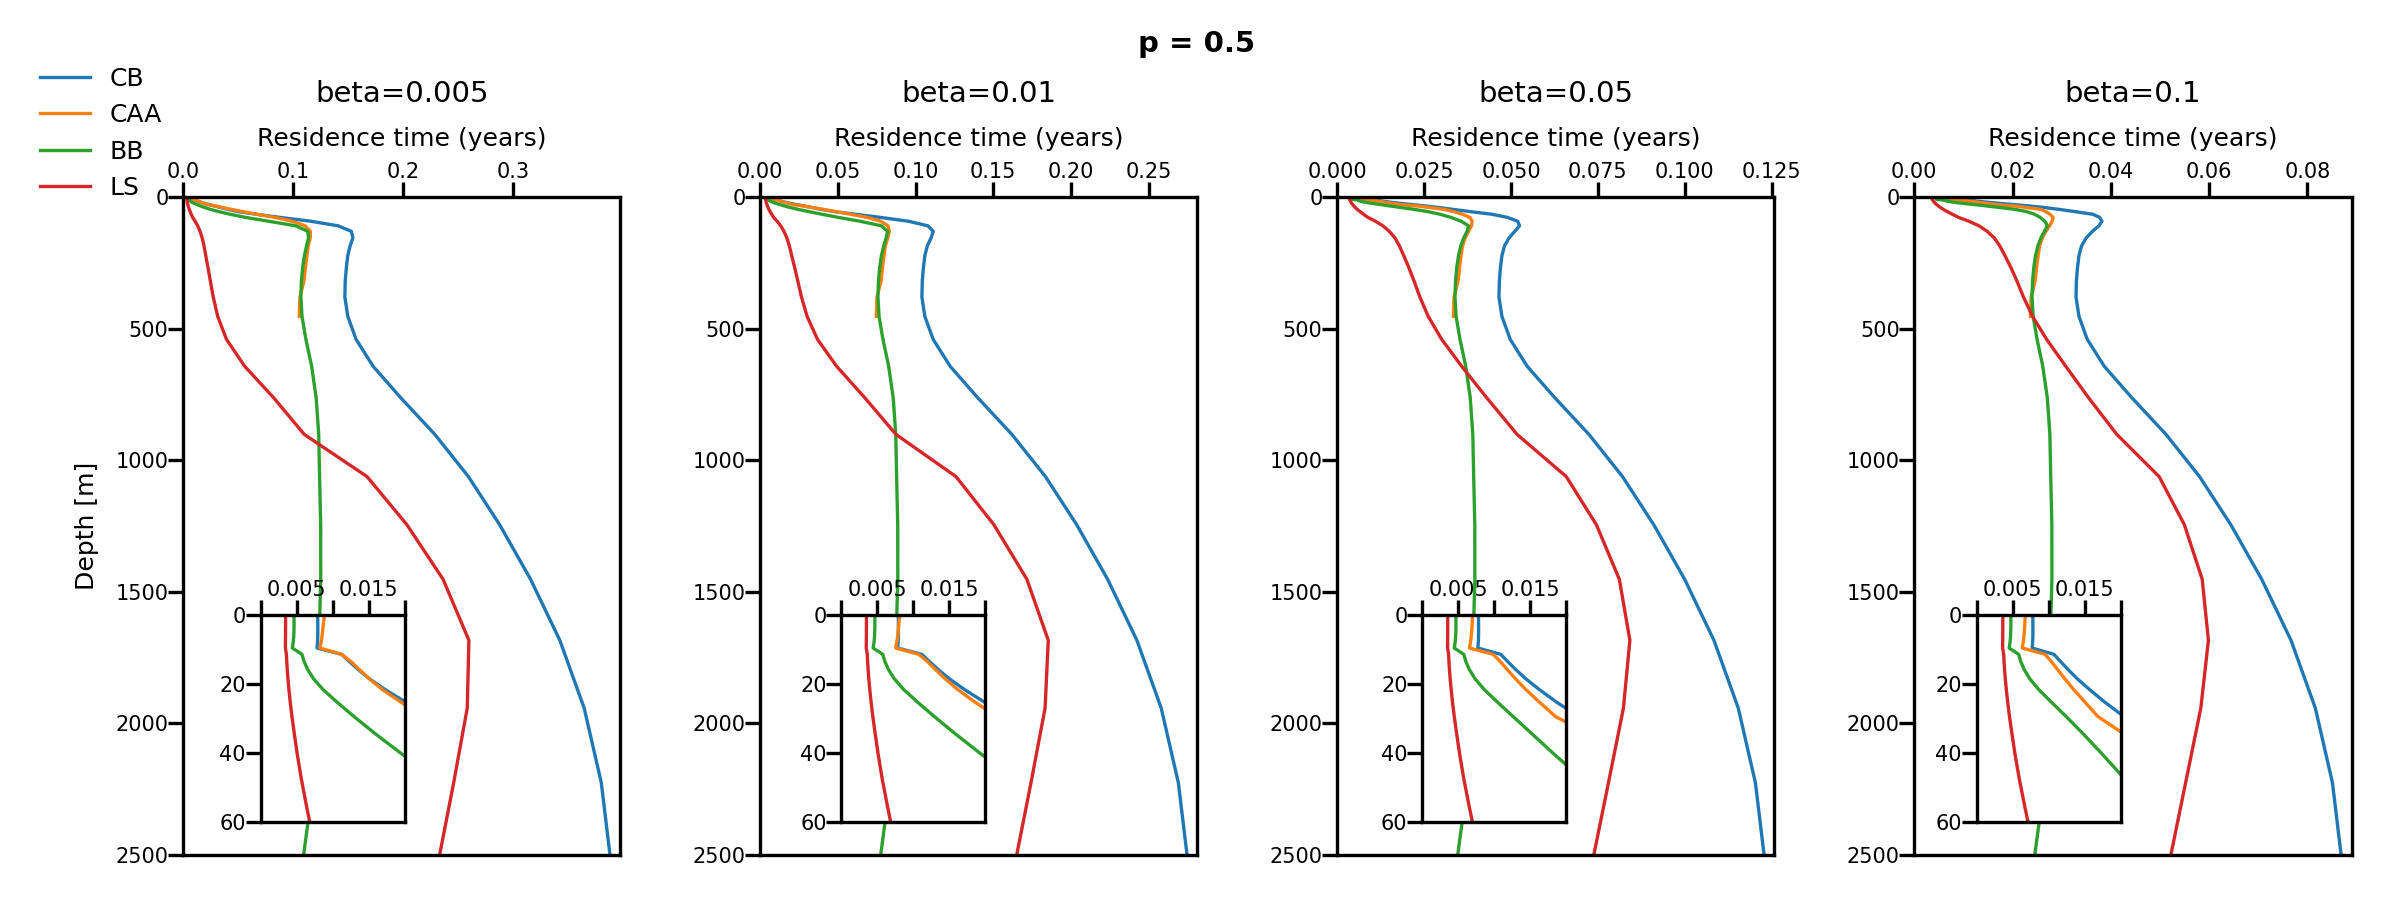

In [119]:
fig = {}
for power in power_exps:
    fig[f'p{power}'] = plot_regional_tau(tau, keys=[f'p{power}-b{betas[0]}',f'p{power}-b{betas[1]}',
                                                    f'p{power}-b{betas[2]}',f'p{power}-b{betas[3]}'])    

In [273]:
# kscav1 = calc_kscav(beta=0.005, power=0.25)
# kscav2 = calc_kscav(beta=0.01,  power=0.25)
# kscav3 = calc_kscav(beta=0.05,  power=0.25)
# kscav4 = calc_kscav(beta=0.10,  power=0.25)

In [278]:
# tau1   = calc_residence_time_kscav(kscav1/np.amax(kscav1), k=5e-8, regional=True) # scales it so that residence time is never < 0.6 yr
# tau2   = calc_residence_time_kscav(kscav2/np.amax(kscav2), k=5e-8, regional=True) # set by the value of k. Maybe that is a reasonable
# tau3   = calc_residence_time_kscav(kscav3/np.amax(kscav3), k=5e-8, regional=True) # way to scale the range of kscav values covered
# tau4   = calc_residence_time_kscav(kscav4/np.amax(kscav4), k=5e-8, regional=True)

Next steps: make it automatically estimate k (probably based on min kscav and multiply by 60-80 for residence time in deep), then apply grid print of versions of this figure to a pdf to look at.

In [120]:
pdf = matplotlib.backends.backend_pdf.PdfPages("/ocean/brogalla/GEOTRACES/figures/Pb-scavenging-tuning-check.pdf")
for power in power_exps:
    pdf.savefig(fig[f'p{power}'])
pdf.close()

Normalization here is for ease of comparison between plots, for deciding final values I'll need to remove that

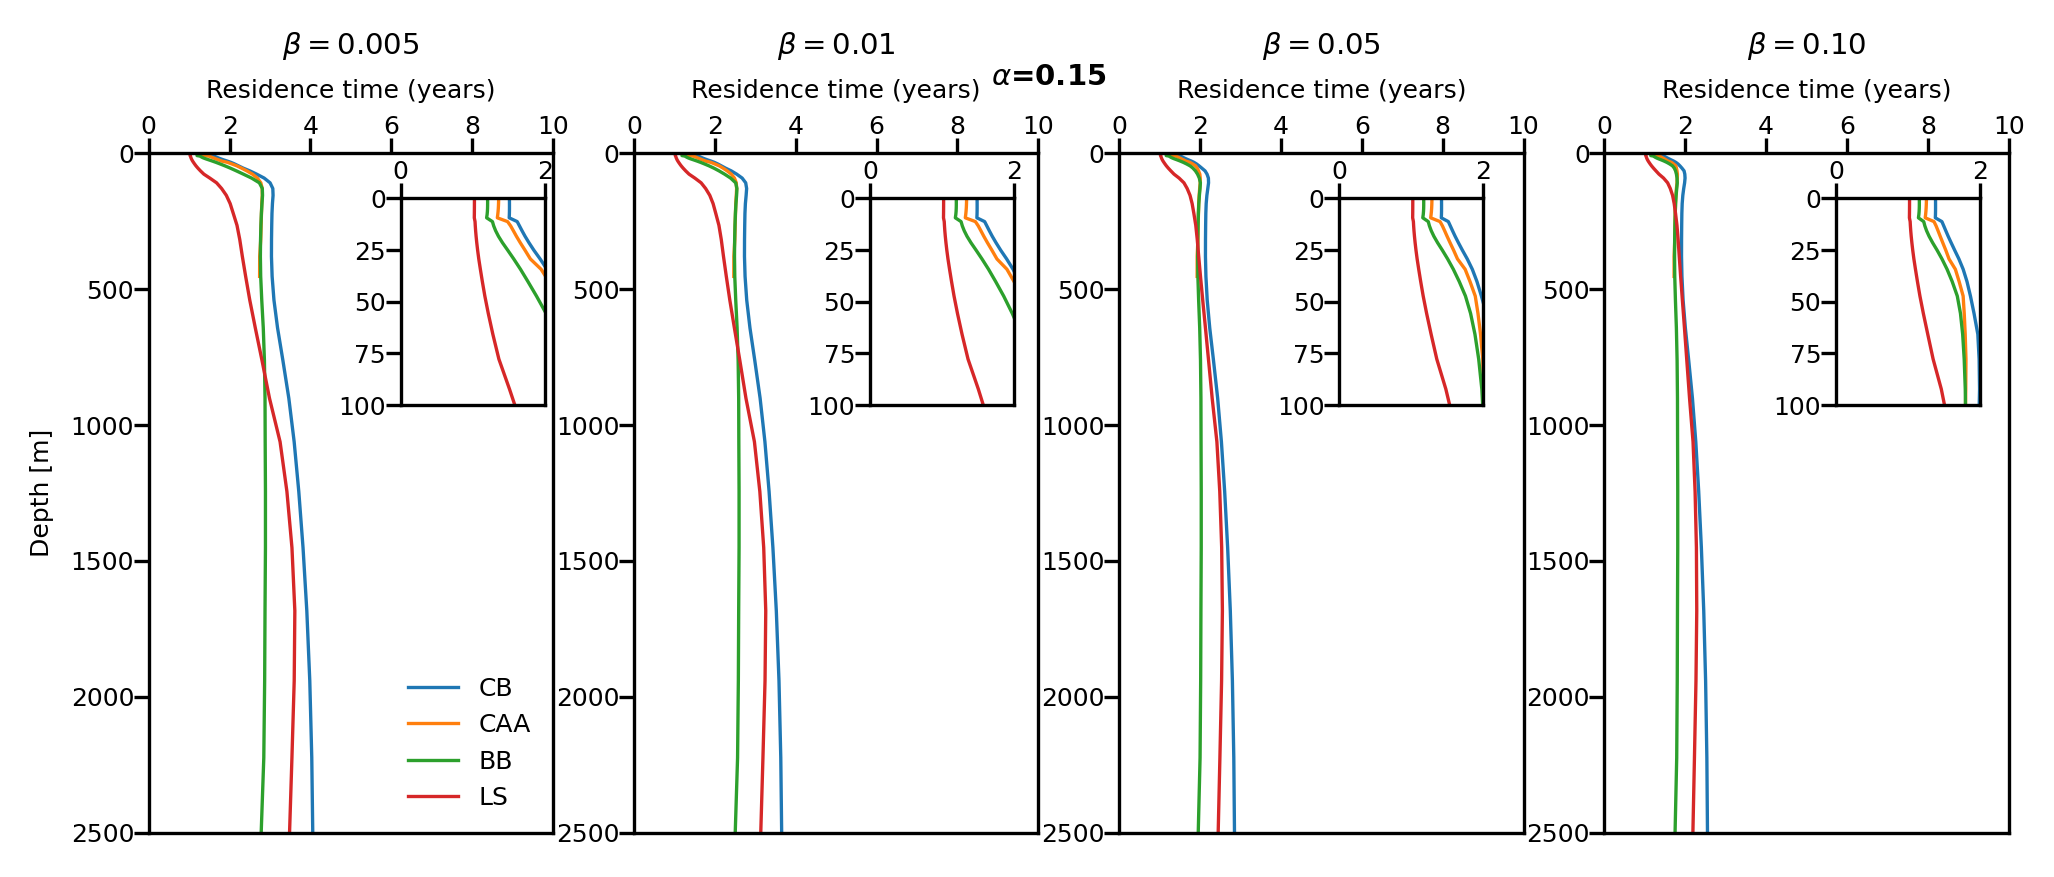

In [272]:
fig, ax = plt.subplots(1, 4, figsize=(8,3), dpi=300)

fig.suptitle(r'$\alpha$=0.15', fontsize=7, fontweight='bold')

for axis in ax.ravel():
    axis.set_ylim(2500,0);
    axis.set_xlim(0,10);
    axis.set_xlabel('Residence time (years)', fontsize=6)
    
ax[0].set_ylabel('Depth [m]', fontsize=6)
plot_regional(ax[0], tau1, r'$\beta=0.005$', legend=True)
plot_regional(ax[1], tau2, r'$\beta=0.01$')
plot_regional(ax[2], tau3, r'$\beta=0.05$')
plot_regional(ax[3], tau4, r'$\beta=0.10$')

left, bottom, width, height = [0.23, 0.6, 0.06, 0.23]
ax1 = fig.add_axes([left, bottom, width, height]);
ax2 = fig.add_axes([left*1.85, bottom, width, height]);
ax3 = fig.add_axes([left*2.7, bottom, width, height]);
ax4 = fig.add_axes([left*3.6, bottom, width, height]); 
plot_regional(ax1, tau1, '')
plot_regional(ax2, tau2, '')
plot_regional(ax3, tau3, '')
plot_regional(ax4, tau4, '')

for axis in [ax1,ax2,ax3,ax4]:
    axis.set_ylim(100,0);
    axis.set_xlim(0,2);

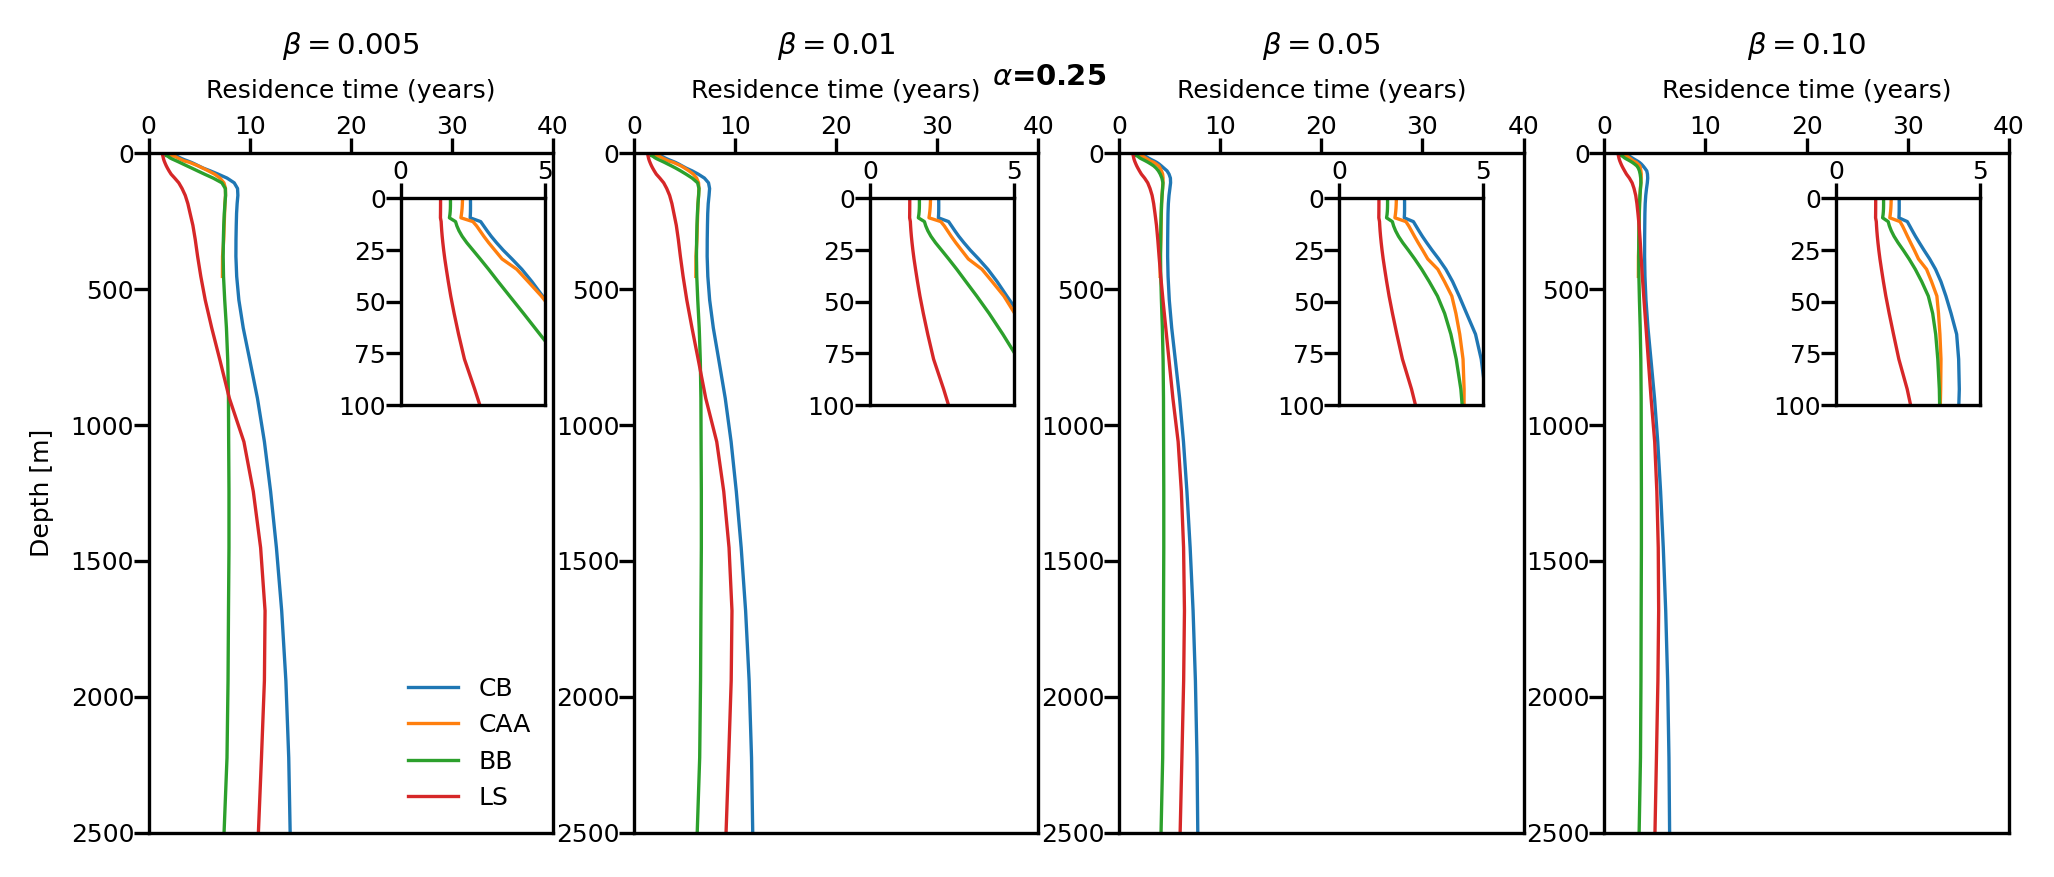

In [280]:
fig, ax = plt.subplots(1, 4, figsize=(8,3), dpi=300)

fig.suptitle(r'$\alpha$=0.25', fontsize=7, fontweight='bold')

for axis in ax.ravel():
    axis.set_ylim(2500,0);
    axis.set_xlim(0,40);
    axis.set_xlabel('Residence time (years)', fontsize=6)
    
ax[0].set_ylabel('Depth [m]', fontsize=6)
plot_regional(ax[0], tau1, r'$\beta=0.005$', legend=True)
plot_regional(ax[1], tau2, r'$\beta=0.01$')
plot_regional(ax[2], tau3, r'$\beta=0.05$')
plot_regional(ax[3], tau4, r'$\beta=0.10$')

left, bottom, width, height = [0.23, 0.6, 0.06, 0.23]
ax1 = fig.add_axes([left, bottom, width, height]);
ax2 = fig.add_axes([left*1.85, bottom, width, height]);
ax3 = fig.add_axes([left*2.7, bottom, width, height]);
ax4 = fig.add_axes([left*3.6, bottom, width, height]); 
plot_regional(ax1, tau1, '')
plot_regional(ax2, tau2, '')
plot_regional(ax3, tau3, '')
plot_regional(ax4, tau4, '')

for axis in [ax1,ax2,ax3,ax4]:
    axis.set_ylim(100,0);
    axis.set_xlim(0,5);

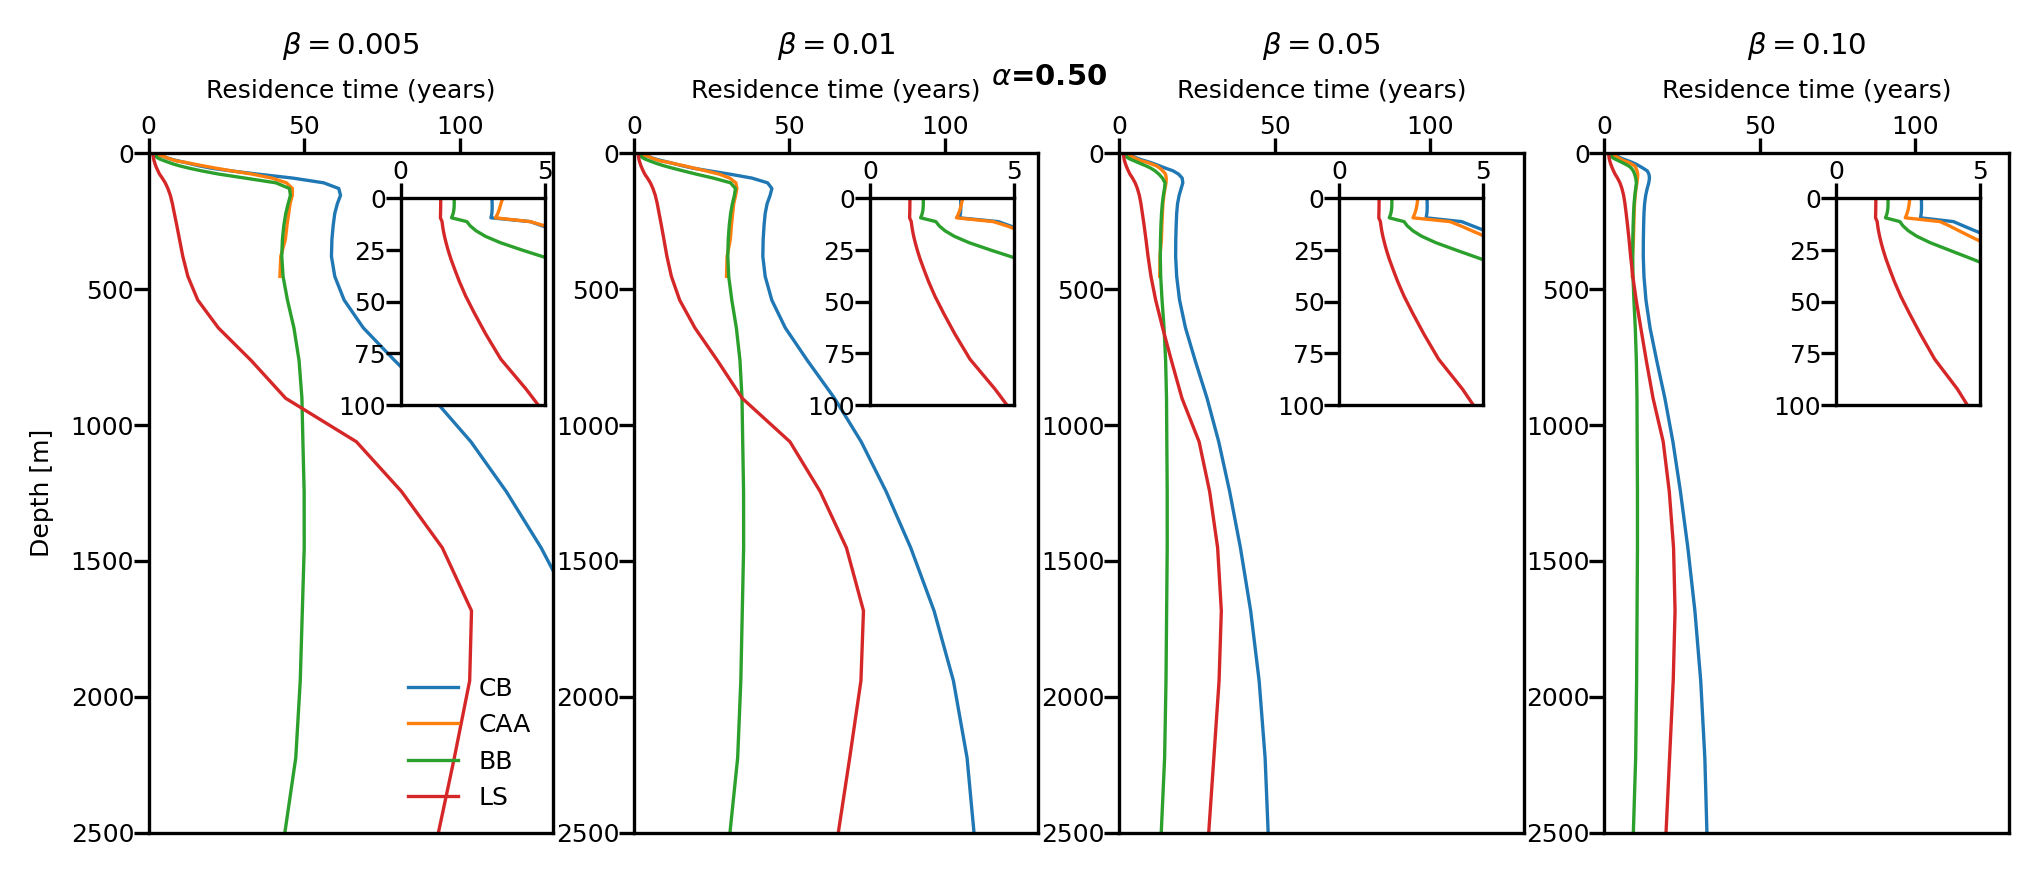

In [257]:
fig, ax = plt.subplots(1, 4, figsize=(8,3), dpi=300)

fig.suptitle(r'$\alpha$=0.50', fontsize=7, fontweight='bold')

for axis in ax.ravel():
    axis.set_ylim(2500,0);
    axis.set_xlim(0,130);
    axis.set_xlabel('Residence time (years)', fontsize=6)
    
ax[0].set_ylabel('Depth [m]', fontsize=6)
plot_regional(ax[0], tau1, r'$\beta=0.005$', legend=True)
plot_regional(ax[1], tau2, r'$\beta=0.01$')
plot_regional(ax[2], tau3, r'$\beta=0.05$')
plot_regional(ax[3], tau4, r'$\beta=0.10$')

left, bottom, width, height = [0.23, 0.6, 0.06, 0.23]
ax1 = fig.add_axes([left, bottom, width, height]);
ax2 = fig.add_axes([left*1.85, bottom, width, height]);
ax3 = fig.add_axes([left*2.7, bottom, width, height]);
ax4 = fig.add_axes([left*3.6, bottom, width, height]); 
plot_regional(ax1, tau1, '')
plot_regional(ax2, tau2, '')
plot_regional(ax3, tau3, '')
plot_regional(ax4, tau4, '')

for axis in [ax1,ax2,ax3,ax4]:
    axis.set_ylim(100,0);
    axis.set_xlim(0,5);

### Figures

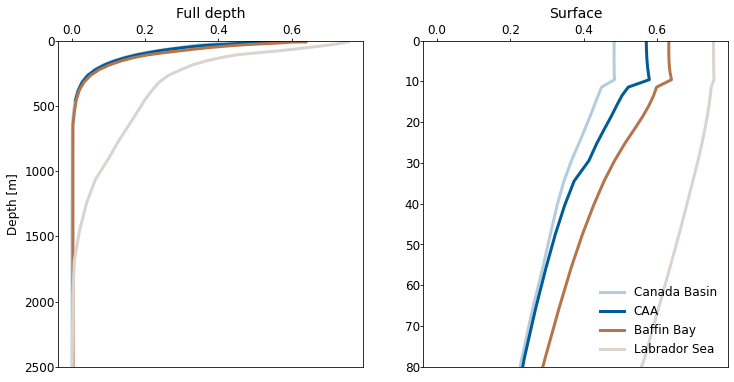

In [81]:
particle_figure(np.nansum(kscav[:,:,:,:],axis=0)/np.amax(np.nansum(kscav[:,:,:,:],axis=0))) # beta=0.10, power=0.15 new method

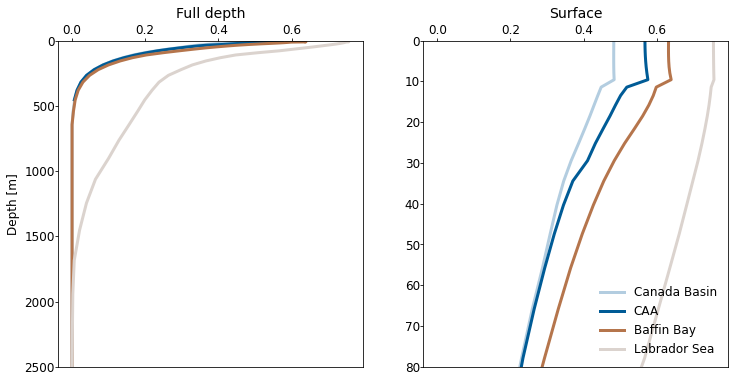

In [76]:
particle_figure(np.nansum(kscav[:,:,:,:],axis=0)/np.amax(np.nansum(kscav[:,:,:,:],axis=0))) # beta=0.01, power=0.15 new method

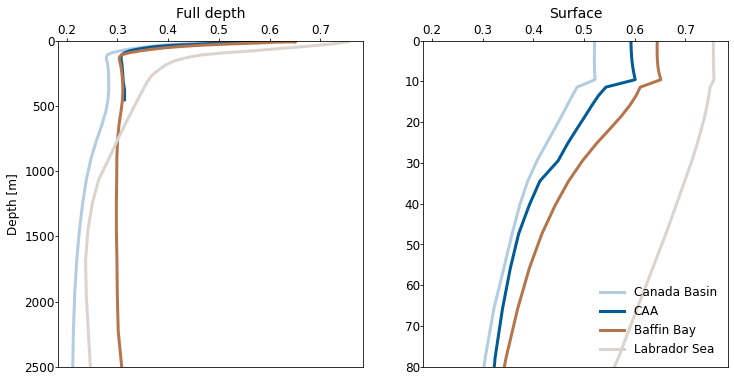

In [63]:
particle_figure(np.nansum(kscav[:,:,:,:],axis=0)/np.amax(np.nansum(kscav[:,:,:,:],axis=0))) # beta = 0.01, power=0.15 old method (power of all)